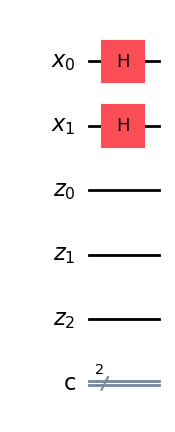

In [1]:
# Step 1: Import and create registers
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT

# Create input (x), value (z) and classical (c) registers
n_input = 2    # Input qubits: x0, x1
m_value = 3    # Value qubits: encoding f(x) values
x = QuantumRegister(n_input, name='x')
z = QuantumRegister(m_value, name='z')
c = ClassicalRegister(n_input, name='c')  # Only measure input qubits
qc = QuantumCircuit(x, z, c)

# Step 2: Apply Hadamard to input
qc.h(x)


qc.draw('mpl')

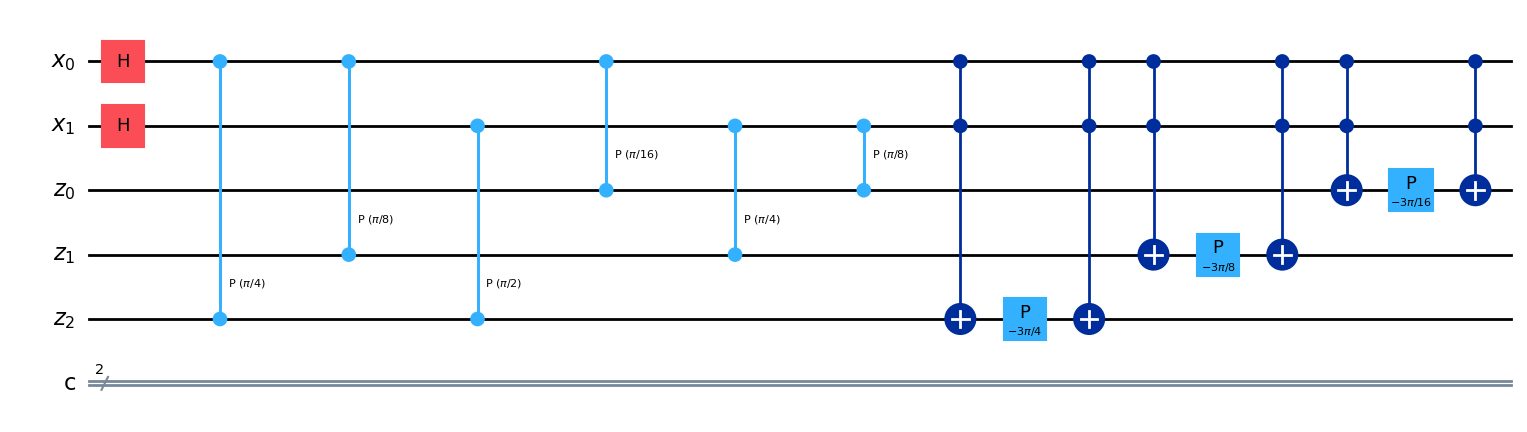

In [2]:
# Step 3: Encode QUBO function using controlled phase rotations

import numpy as np


coefficients = {
    (0,): 1,        # +1 * x0
    (1,): 2,        # +2 * x1
    (0,1): -3       # -3 * x0 * x1
}

for key, value in coefficients.items(): #loop through the each monomial 
    theta = 2 * np.pi * value / (2**m_value)  # each co-eff into rotation angle, divided by 2**m_value(8) coz it can store numbers upto this value
    controls = [x[i] for i in key] # select control qubit from i/p
    targets = z

    if len(controls) == 1: #for single variable
        for j in range(m_value):
            qc.cp(theta / (2**j), controls[0], targets[m_value - j - 1]) # apply cp gates on every value registers
    elif len(controls) == 2: #two variable term
        for j in range(m_value):
            qc.mcx(controls, targets[m_value - j - 1]) #MCX to convert two controls into 1 target
            qc.p(theta / (2**j), targets[m_value - j - 1]) #apply (p gate), theta / (2**j) based on qubit importance(binary weight)
            qc.mcx(controls, targets[m_value - j - 1]) #undo the MCX to unentangle
qc.draw('mpl')

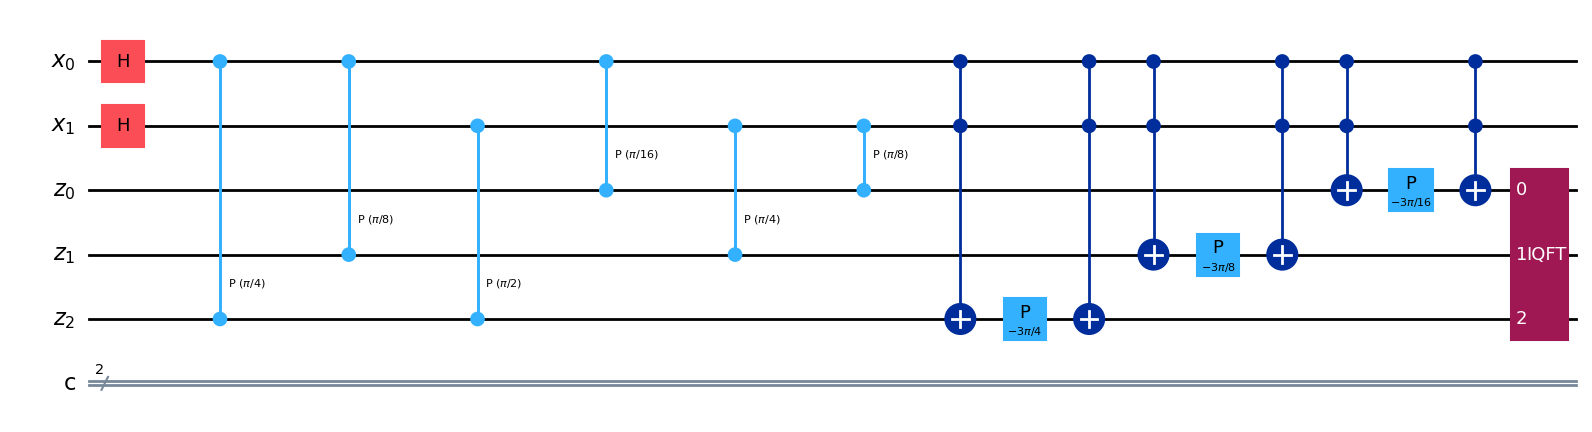

In [3]:
# Step 4: Apply Inverse QFT to value register; decode the P info classical Binary info which is hidden inside the Q P of Zs; i/p are still in superposition

from qiskit.circuit.library import QFT
qc.append(QFT(num_qubits=m_value, do_swaps=False, inverse=True), z)
qc.draw('mpl')

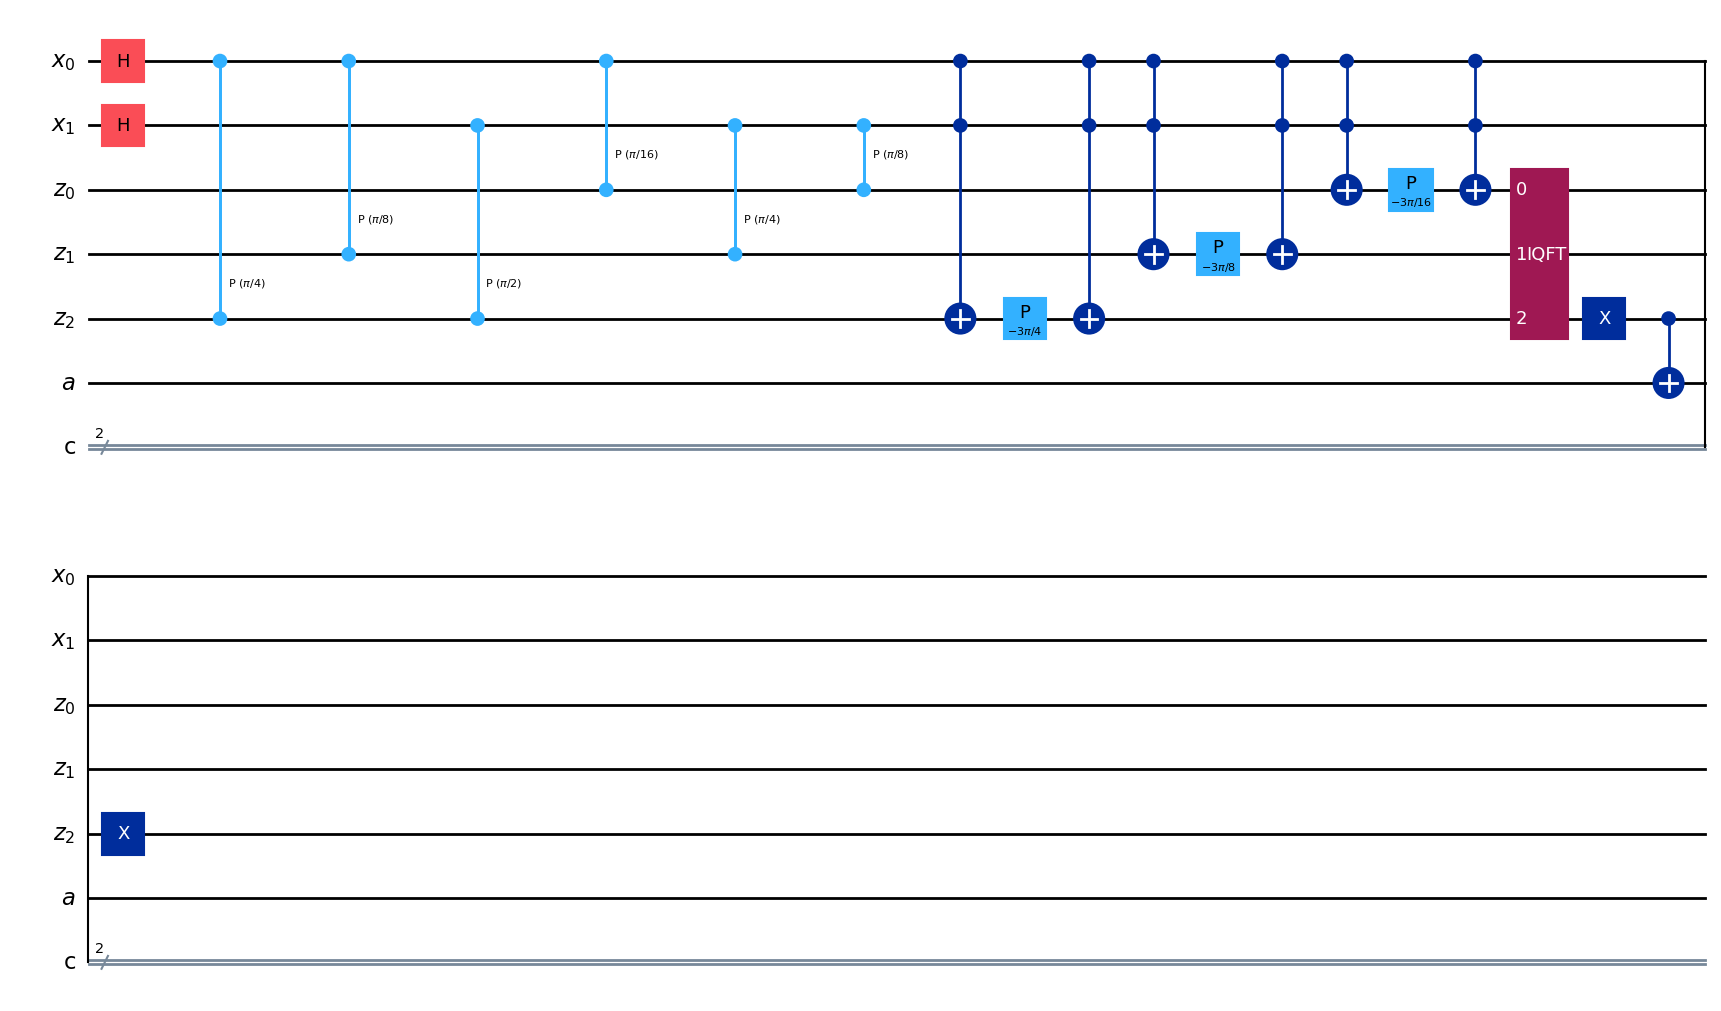

In [4]:
# Step 5: Oracle - Mark good solutions
# Create an ancilla qubit if not already created
from qiskit import QuantumRegister

a = QuantumRegister(1, name='a')  # 1 ancilla qubit
qc.add_register(a)

# Flip ancilla if MSB (z[m_value-1]) is 0
qc.x(z[m_value-1])          # Invert MSB; to trick Qiskit's control logic coz it only triggers at 1 but MSB must be 0 gor good value
qc.cx(z[m_value-1], a[0])    # Controlled flip ancilla
qc.x(z[m_value-1])           # Undo invert; cant change the value register permanently

qc.draw('mpl')

PennyLane


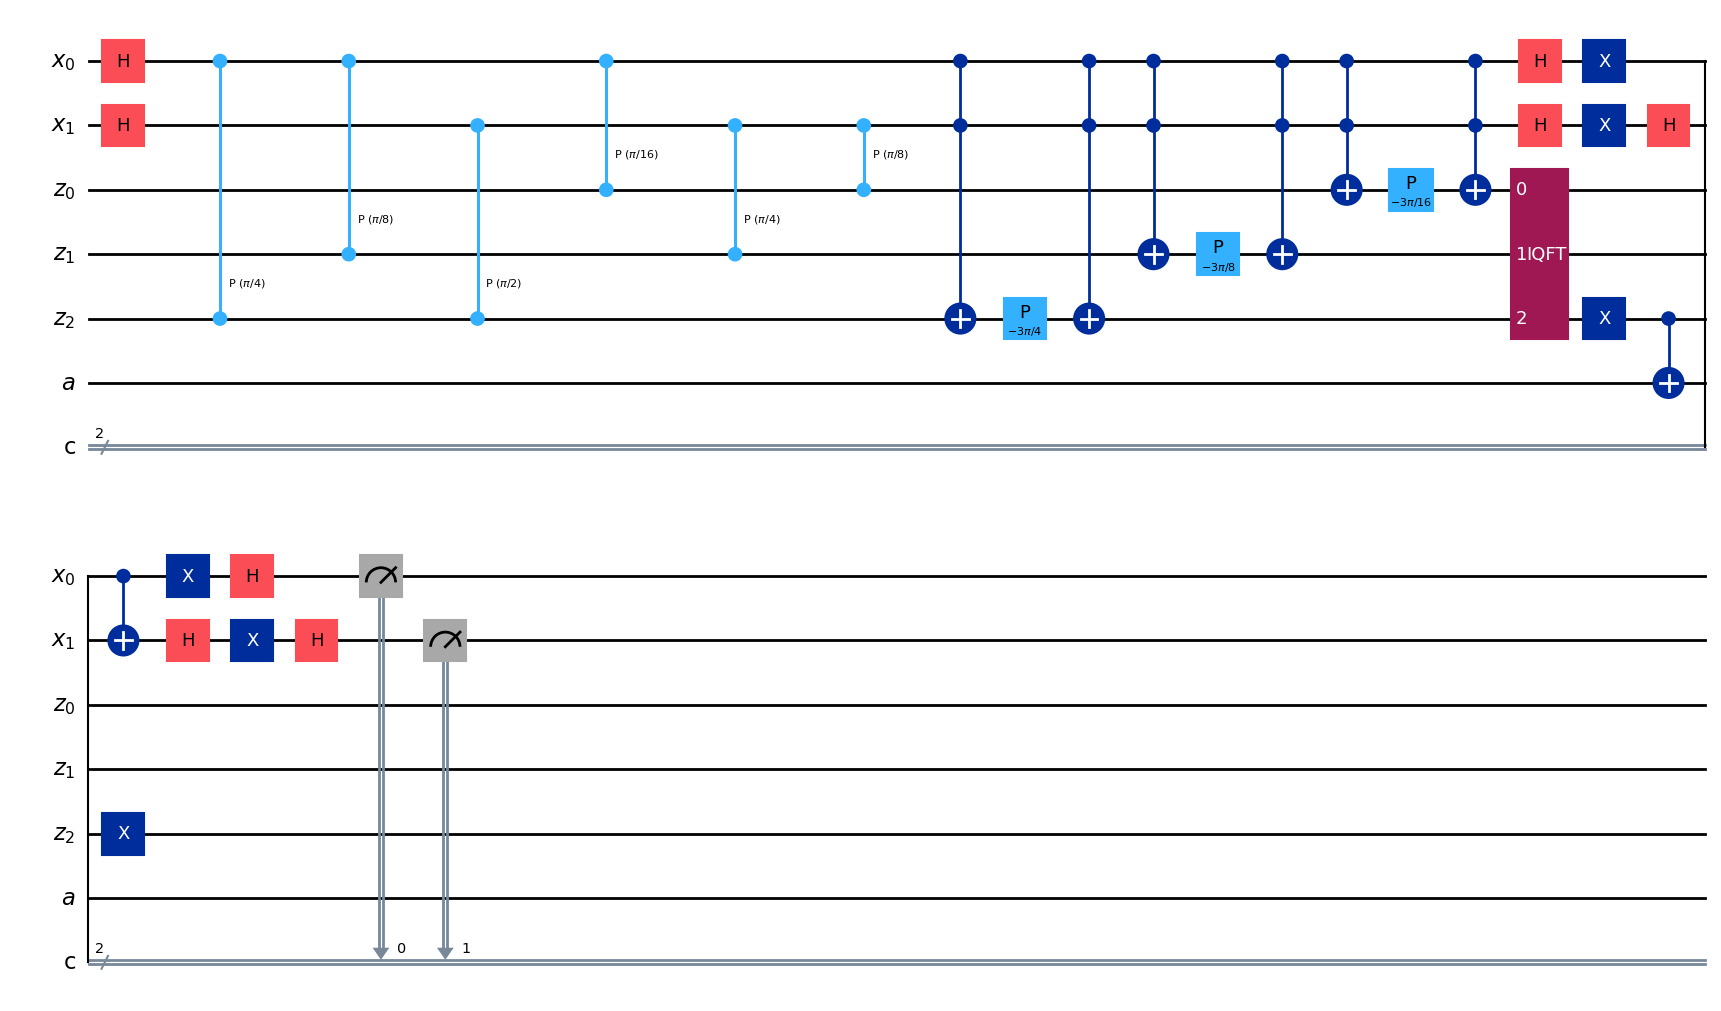

In [5]:
# Apply Hadamard
qc.h(x)
# Apply X
qc.x(x)
# Multi-controlled Z
qc.h(x[-1])
if len(x) > 1:
    qc.mcx(x[:-1], x[-1])
else:
    qc.z(x[0])
qc.h(x[-1])
# Apply X again
qc.x(x)
# Apply Hadamard again
qc.h(x)

# Step 7: Measurement
qc.measure(x, c)

# Final: Draw circuit
qc.draw('mpl')  

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define input and value registers
n_input = 2    # Input qubits: x0, x1
m_value = 3    # Value qubits: for f(x) in [0, 3]
total_wires = n_input + m_value

# Step 2: Create a device
dev = qml.device("default.qubit", wires=total_wires)

# Step 3: Define f(x) = x0 + 2*x1 using controlled-NOTs to value qubits
@qml.qnode(dev)
def circuit():
    # Step 3.1: Put input qubits in superposition
    for i in range(n_input):
        qml.Hadamard(wires=i)

    # Step 3.2: Encode f(x) = x0 + 2*x1 into value qubits (binary encoding)
    # For x0, add 1 (control: x0 -> target: value[0])
    qml.CNOT(wires=[0, 2])

    # For x1, add 2 (control: x1 -> target: value[1])
    qml.CNOT(wires=[1, 3])

    # Optional: visualize using third value qubit if needed (e.g., to extend range)

    # Step 3.3: Measure all qubits
    return qml.probs(wires=range(total_wires))

# Step 4: Draw the circuit
print(qml.draw(circuit)())

# Step 5: Run the circuit
result = circuit()

# Step 6: Print result
print("Output probabilities for input and value qubits:")
print(result)


0: ──H─╭●────┤ ╭Probs
1: ──H─│──╭●─┤ ├Probs
2: ────╰X─│──┤ ├Probs
3: ───────╰X─┤ ├Probs
4: ──────────┤ ╰Probs
Output probabilities for input and value qubits:
[0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.25 0.  ]


In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

n_input = 2
m_value = 2
total_wires = n_input + m_value + 1  # 2 input, 2 value, 1 ancilla
dev = qml.device("default.qubit", wires=total_wires, shots=100)

def f_encoding():
    qml.CNOT(wires=[0, 2])  # x0 → value[0]
    qml.CNOT(wires=[1, 3])  # x1 → value[1]

def oracle(thresh):
    if thresh == 1:
        qml.X(wires=3)
        qml.Toffoli(wires=[2, 3, 4])
        qml.X(wires=3)
    elif thresh == 2:
        qml.Toffoli(wires=[2, 3, 4])
    elif thresh >= 3:
        qml.CNOT(wires=[3, 4])  # flip ancilla if MSB = 1

def diffuser():
    for i in range(n_input):
        qml.Hadamard(wires=i)
        qml.X(wires=i)
    qml.Hadamard(wires=n_input-1)
    qml.ctrl(qml.Z, [0])(1)
    qml.Hadamard(wires=n_input-1)
    for i in range(n_input):
        qml.X(wires=i)
        qml.Hadamard(wires=i)

@qml.qnode(dev)
def grover_iteration(thresh):
    for i in range(n_input):
        qml.Hadamard(wires=i)
    f_encoding()
    oracle(thresh)
    f_encoding()
    diffuser()
    return qml.sample(wires=range(n_input))

def f(x_bits):
    return x_bits[0] + 2 * x_bits[1]

# GAS loop
threshold = 3
best_x = None
best_fx = float('inf')
no_improve_counter = 0
max_no_improve = 3
history = []

while no_improve_counter < max_no_improve:
    samples = grover_iteration(threshold)
    counts = Counter(tuple(s) for s in samples)
    top_x = max(counts.items(), key=lambda x: x[1])[0]
    top_fx = f(top_x)
    
    history.append((top_x, top_fx, threshold))

    print(f"\n Iteration with threshold {threshold}")
    print(f" Measured: {top_x} (f = {top_fx})")

    if top_fx < best_fx:
        best_fx = top_fx
        best_x = top_x
        threshold = best_fx
        no_improve_counter = 0
        print(" Found better solution.")
    else:
        no_improve_counter += 1
        print(" No improvement.")

print(f"\n Finished: Best solution = {best_x}, f = {best_fx}")



 Iteration with threshold 3
 Measured: (np.int64(0), np.int64(1)) (f = 2)
 Found better solution.

 Iteration with threshold 2
 Measured: (np.int64(1), np.int64(1)) (f = 3)
 No improvement.

 Iteration with threshold 2
 Measured: (np.int64(0), np.int64(1)) (f = 2)
 No improvement.

 Iteration with threshold 2
 Measured: (np.int64(1), np.int64(0)) (f = 1)
 Found better solution.

 Iteration with threshold 1
 Measured: (np.int64(1), np.int64(0)) (f = 1)
 No improvement.

 Iteration with threshold 1
 Measured: (np.int64(1), np.int64(1)) (f = 3)
 No improvement.

 Iteration with threshold 1
 Measured: (np.int64(1), np.int64(0)) (f = 1)
 No improvement.

 Finished: Best solution = (np.int64(1), np.int64(0)), f = 1


In [5]:
import pennylane as qml
from pennylane import numpy as np
from math import pi
from collections import Counter

# QUBO problem (you can modify this!)
Q = np.array([
    [1, -1, 0, 0, 0],
    [-1, 2, 1, 0, 0],
    [0, 1, 3, -1, 0],
    [0, 0, -1, 2, 1],
    [0, 0, 0, 1, 1]
])
b = np.array([-1, 2, 0, -2, 1])

# Constraint: total weight <= 3
c_vec = np.array([1, 1, 1, 1, 1])
budget = 3


In [6]:
import matplotlib.pyplot as plt
# Step 2: Define wires and device
n_input = 5         # number of binary decision variables
m_value = 4         # qubits to represent f(x)
m_constraint = 3    # qubits to represent constraint sum

# Allocate wires for each register
input_wires = list(range(n_input))                                         # [0, 1, 2, 3, 4]
value_wires = list(range(n_input, n_input + m_value))                      # [5, 6, 7, 8]
constraint_wires = list(range(n_input + m_value, n_input + m_value + m_constraint))  # [9, 10, 11]

# Allocate ancilla wires
fx_check = 12              # flips if f(x) ≥ threshold
constraint_check = 13      # flips if constraint > budget
marker = 14                # final flag if both conditions are met

# Total wires needed
all_wires = input_wires + value_wires + constraint_wires + [fx_check, constraint_check, marker]
total_wires = max(all_wires) + 1

# Define quantum device
dev = qml.device("default.qubit", wires=total_wires, shots=200)



# Draw the initial circuit (graphical)
from pennylane import draw_mpl
fig, ax = draw_mpl(grover_circuit)(thresh=6)
plt.tight_layout()
plt.show()


NameError: name 'grover_circuit' is not defined

C:\Users\SheikSulaima\AppData\Local\Temp\ipykernel_16616\1131744559.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


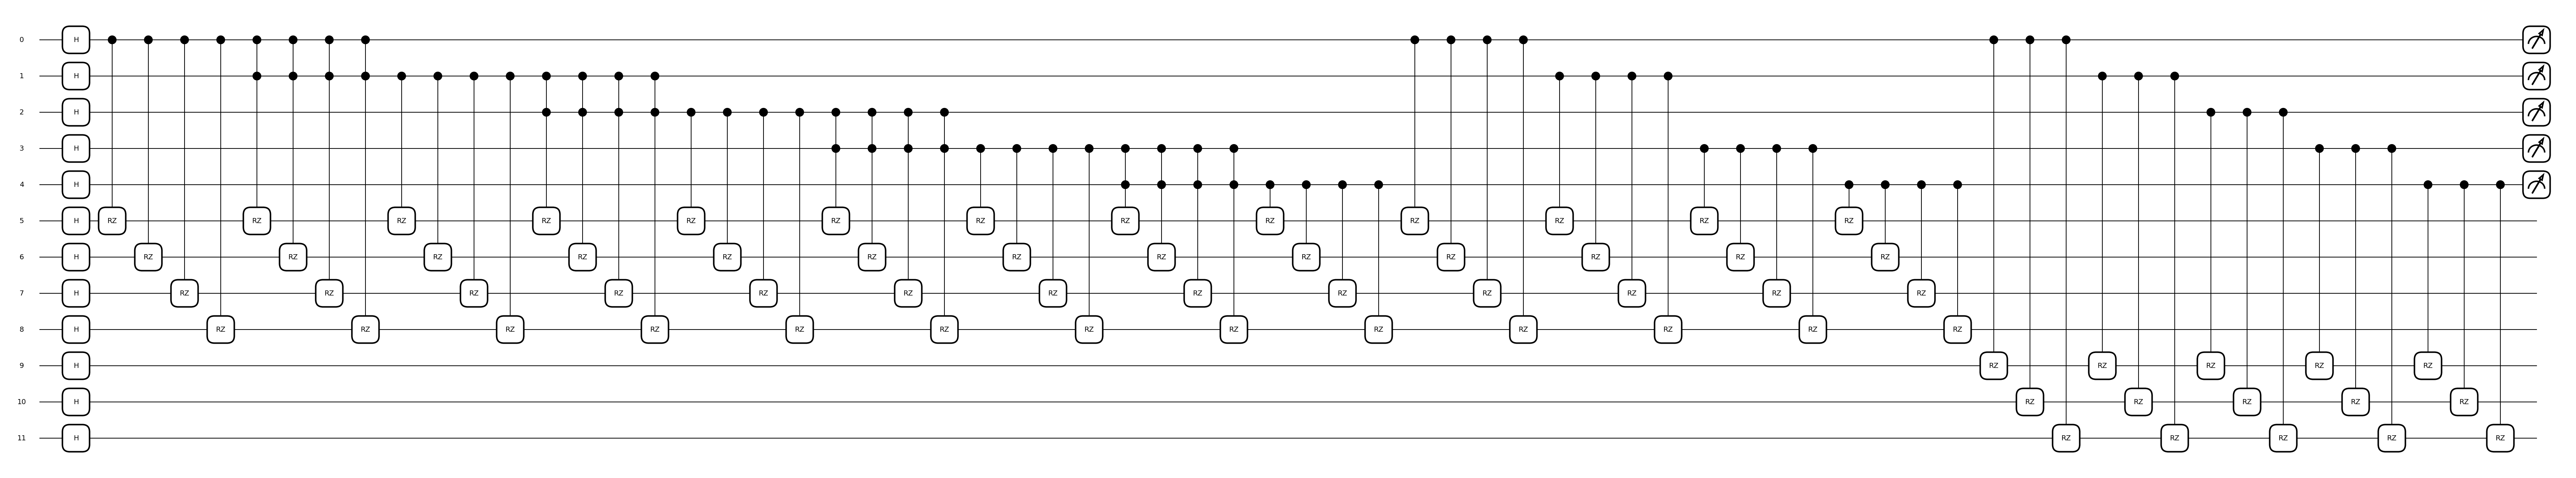

In [ ]:
# Step 3: Encode QUBO in phase
def encode_qubo_phase():
    for i in range(n_input):
        for j in range(i, n_input):
            coeff = Q[i, j]
            if coeff != 0:
                for k in range(m_value):
                    angle = 2 * pi * coeff / (2 ** (k + 1))
                    if i == j:
                    # Apply single-controlled RZ for diagonal terms
                        qml.ctrl(qml.RZ, control=[input_wires[i]])(angle, wires=value_wires[k])
                    else:
                    # Apply double-controlled RZ for off-diagonal
                        qml.ctrl(qml.RZ, control=[input_wires[i], input_wires[j]])(angle, wires=value_wires[k])

    for i in range(n_input):
        coeff = b[i]
        if coeff != 0:
            for k in range(m_value):
                angle = 2 * pi * coeff / (2 ** (k + 1))
                qml.ctrl(qml.RZ, control=[input_wires[i]])(angle, wires=value_wires[k])

# Step 3: Encode constraint in phase
def encode_constraint_phase():
    for i in range(n_input):
        coeff = c_vec[i]
        if coeff != 0:
            for k in range(m_constraint):
                angle = 2 * pi * coeff / (2 ** (k + 1))
                qml.ctrl(qml.RZ, control=[input_wires[i]])(angle, wires=constraint_wires[k])

@qml.qnode(dev)
def grover_circuit(thresh):
    for w in input_wires:
        qml.Hadamard(wires=w)
    for w in value_wires:
        qml.Hadamard(wires=w)
    for w in constraint_wires:
        qml.Hadamard(wires=w)

    encode_qubo_phase()
    encode_constraint_phase()

    return qml.sample(wires=input_wires)
fig, ax = draw_mpl(grover_circuit)(thresh=6)
plt.tight_layout()
plt.show()


C:\Users\SheikSulaima\AppData\Local\Temp\ipykernel_16616\3810910193.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


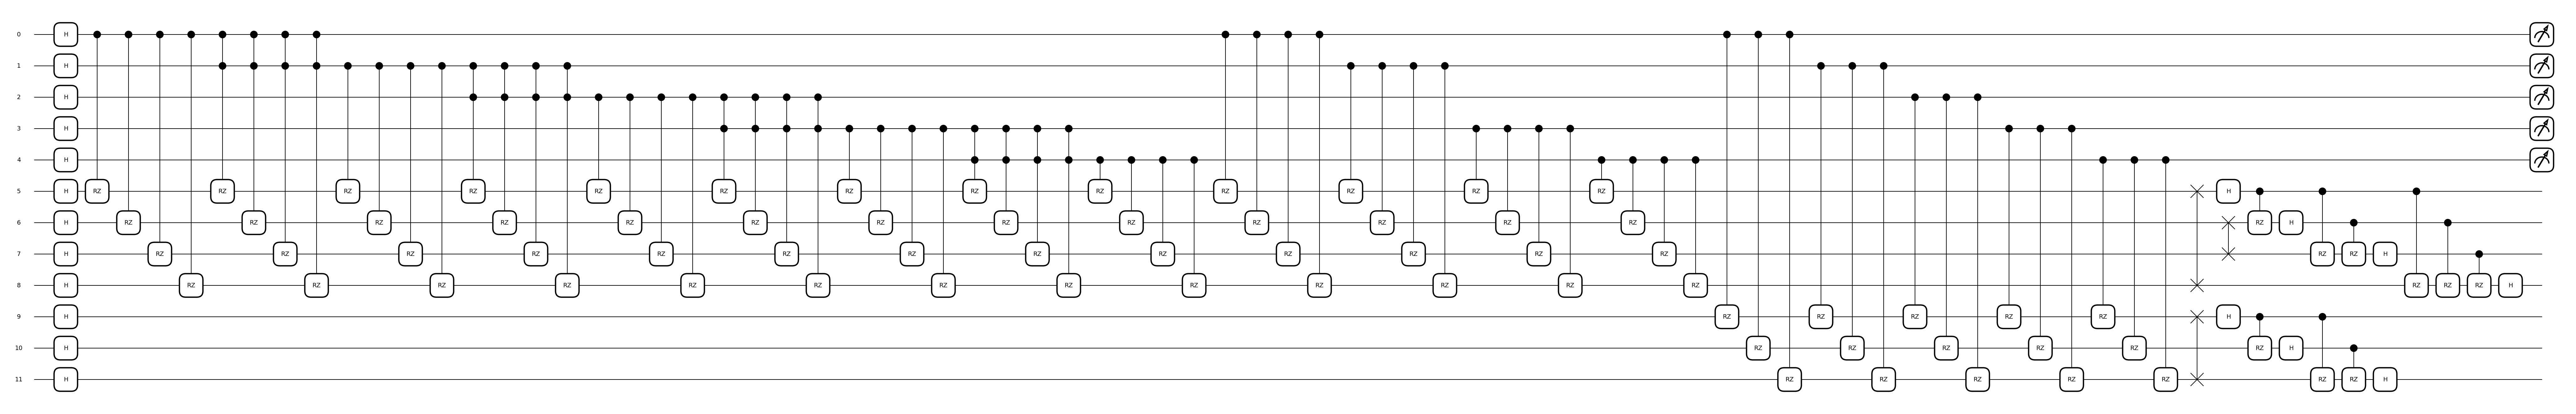

In [ ]:
# Step 4: Inverse QFT function
def inverse_qft(wires):
    n = len(wires)
    # Step 1: Reverse the wire order
    for i in range(n // 2):
        qml.SWAP(wires=[wires[i], wires[n - i - 1]])  # FIXED

    # Step 2: Apply inverse QFT logic
    for j in range(n):
        for k in range(j):
            angle = -pi / (2 ** (j - k))
            qml.ctrl(qml.RZ, control=[wires[k]])(angle, wires=wires[j])
        qml.Hadamard(wires=wires[j])


@qml.qnode(dev)
def grover_circuit(thresh):
    for w in input_wires:
        qml.Hadamard(wires=w)
    for w in value_wires:
        qml.Hadamard(wires=w)
    for w in constraint_wires:
        qml.Hadamard(wires=w)

    encode_qubo_phase()
    encode_constraint_phase()

    inverse_qft(value_wires)
    inverse_qft(constraint_wires)

    return qml.sample(wires=input_wires)

fig, ax = draw_mpl(grover_circuit)(thresh=6)
plt.tight_layout()
plt.show()


C:\Users\SheikSulaima\AppData\Local\Temp\ipykernel_16616\615716650.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


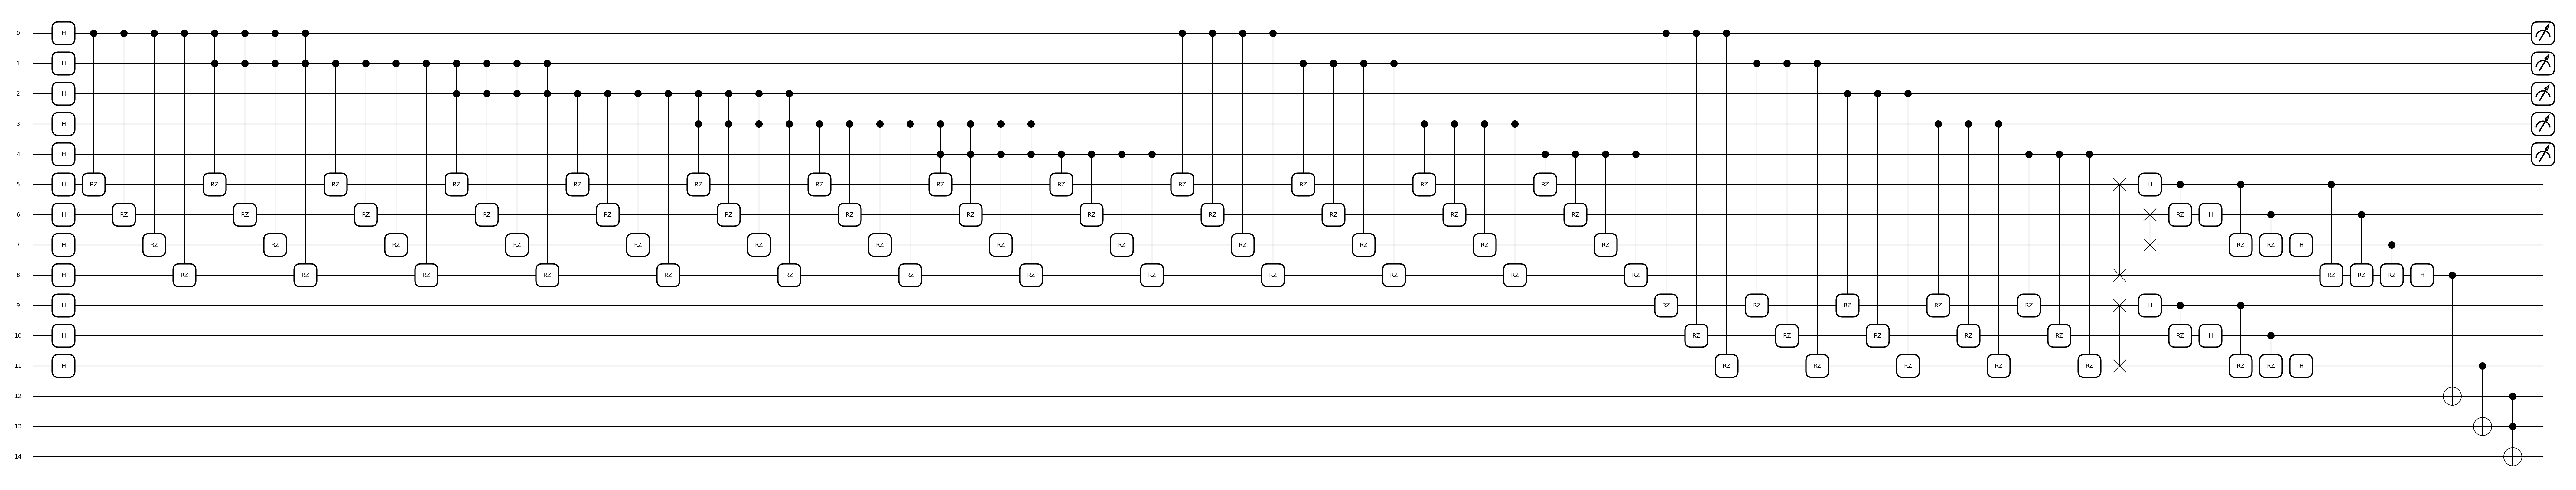

In [ ]:
# Step 5: Oracle - flips marker if f(x) ≥ threshold and constraint violated
def oracle():
    # Check MSB of value register (last qubit in value_wires)
    qml.CNOT(wires=[value_wires[-1], fx_check])

    # Check MSB of constraint register (last qubit in constraint_wires)
    qml.CNOT(wires=[constraint_wires[-1], constraint_check])

    # Flip marker only if both ancillas are 1
    qml.Toffoli(wires=[fx_check, constraint_check, marker])
@qml.qnode(dev)
def grover_circuit(thresh):
    for w in input_wires:
        qml.Hadamard(wires=w)
    for w in value_wires:
        qml.Hadamard(wires=w)
    for w in constraint_wires:
        qml.Hadamard(wires=w)

    encode_qubo_phase()
    encode_constraint_phase()

    inverse_qft(value_wires)
    inverse_qft(constraint_wires)

    oracle()  # Added here!

    return qml.sample(wires=input_wires)
fig, ax = draw_mpl(grover_circuit)(thresh=6)
plt.tight_layout()
plt.show()


C:\Users\SheikSulaima\AppData\Local\Temp\ipykernel_16616\224737080.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


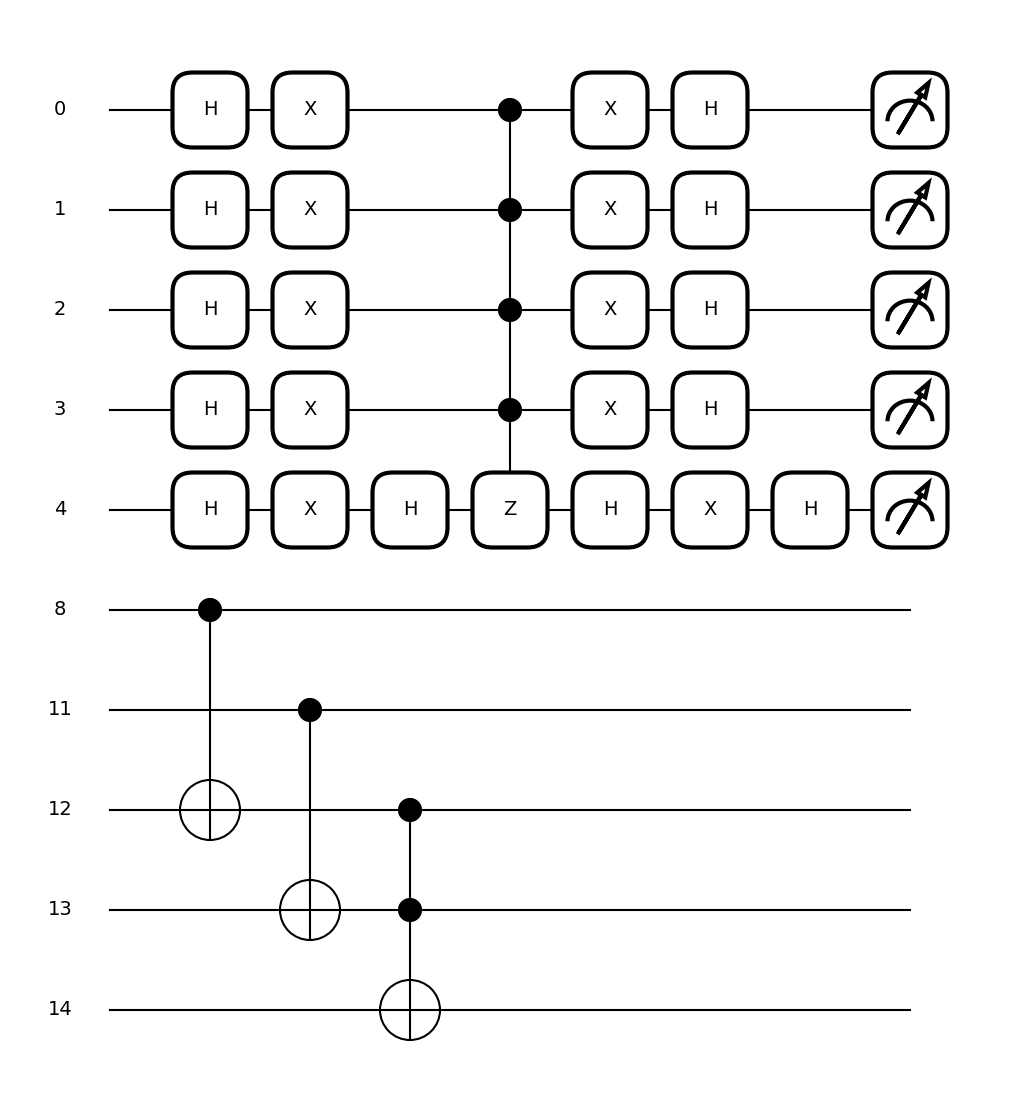

In [ ]:
# Step 6: Grover diffuser - amplifies good (unmarked) solutions
def diffuser():
    for w in input_wires:
        qml.Hadamard(wires=w)
        qml.X(wires=w)

    if len(input_wires) == 1:
        qml.Z(wires=input_wires[0])
    elif len(input_wires) == 2:
        qml.Hadamard(wires=input_wires[1])
        qml.CZ(wires=[input_wires[0], input_wires[1]])
        qml.Hadamard(wires=input_wires[1])
    else:
        qml.Hadamard(wires=input_wires[-1])
        qml.ctrl(qml.Z, control=input_wires[:-1])(wires=input_wires[-1])
        qml.Hadamard(wires=input_wires[-1])

    for w in input_wires:
        qml.X(wires=w)
        qml.Hadamard(wires=w)

# NOW define your QNode (after diffuser is declared)
@qml.qnode(dev)
def grover_circuit(thresh):
    ...
    oracle()
    diffuser()  # This now works
    return qml.sample(wires=input_wires)

fig, ax = draw_mpl(grover_circuit, expansion_strategy="device")(thresh=6)
plt.tight_layout()
plt.show()



🔁 Starting Grover Adaptive Search...

  Sample: x = (np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)), f(x) = 0, count = 200
Threshold: 999, Measured x = (np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)), f(x) = 0
Found better x → updating threshold

  Sample: x = (np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)), f(x) = 0, count = 200
Threshold: 0, Measured x = (np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)), f(x) = 0
⏳ No improvement

  Sample: x = (np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)), f(x) = 0, count = 200
Threshold: 0, Measured x = (np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)), f(x) = 0
⏳ No improvement

  Sample: x = (np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)), f(x) = 0, count = 200
Threshold: 0, Measured x = (np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)), f(x) = 0
⏳ No improvement

🏁 Finished GAS
Best solution: x = (np.int64(

C:\Users\SheikSulaima\AppData\Local\Temp\ipykernel_16616\2587017055.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


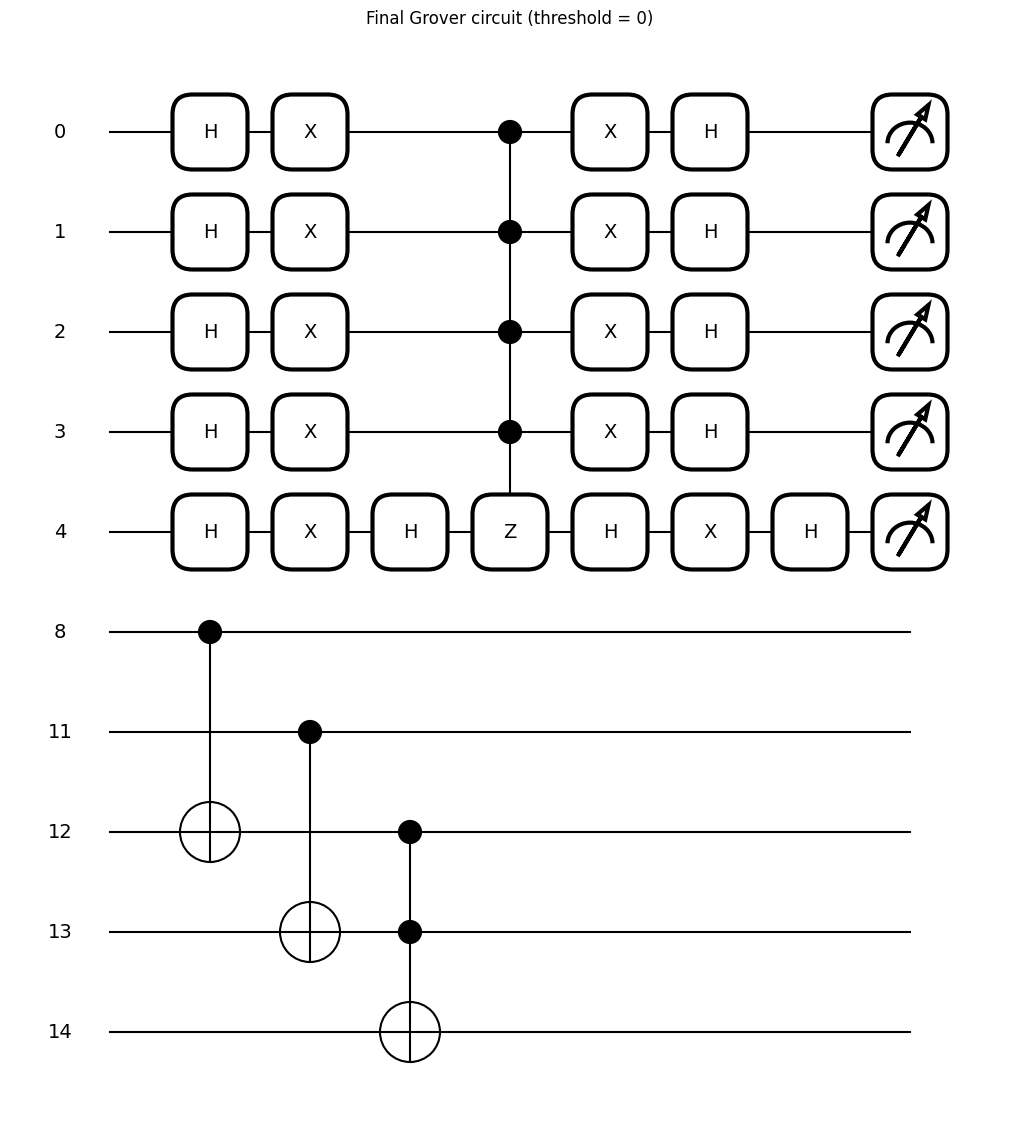

In [ ]:
# Step 7: Classical GAS loop

def f_cost(x_bits):
    """Classical version of the QUBO function f(x)"""
    x = np.array(x_bits)
    return int(x @ Q @ x + b @ x)

threshold = 999  # Start with very high threshold
best_x = None
best_fx = float('inf')
no_improve = 0
max_no_improve = 3

print("\n🔁 Starting Grover Adaptive Search...\n")

while no_improve < max_no_improve:
    samples = grover_circuit(thresh=threshold)
    counts = Counter(tuple(s) for s in samples)
    for x, count in counts.items():
        print(f"  Sample: x = {x}, f(x) = {f_cost(x)}, count = {count}")

    top_x = max(counts.items(), key=lambda x: x[1])[0]
    fx = f_cost(top_x)

    print(f"Threshold: {threshold}, Measured x = {top_x}, f(x) = {fx}")

    if fx < best_fx:
        best_fx = fx
        best_x = top_x
        threshold = fx
        no_improve = 0
        print("Found better x → updating threshold\n")
    else:
        no_improve += 1
        print("⏳ No improvement\n")

print("🏁 Finished GAS")
print(f"Best solution: x = {best_x}, f(x) = {best_fx}")

fig, ax = draw_mpl(grover_circuit, expansion_strategy="device")(thresh=6)
plt.title(f"Final Grover circuit (threshold = {best_fx})")
plt.tight_layout()
plt.show()